 ## Import necessary dependencies

In [1]:
import pandas
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy
from sklearn.feature_selection import chi2
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import re
import sqlite3
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

 ## Read in the data

In [9]:
train_data = pandas.read_csv("./data/train.csv", header=None)
train_data.head()

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [10]:
test_data = pandas.read_csv("./data/test.csv", header=None)
test_data.head()

,0,1,2
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


### Save necessary data in database, first open connection.


In [12]:
db = sqlite3.connect('newsclassifier.db')
cat_list = pandas.read_csv('./data/classes.txt', header=None)
cat_list.head()
cat_list.to_sql("category_list", db, if_exists='replace')

 ## Data Cleaning

In [11]:
train_data.columns = ['category', 'headline', 'content']
train_data.head()

,category,headline,content
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [12]:
test_data.columns = ['category', 'headline', 'content']
test_data.head()

,category,headline,content
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


 ### Sample 1000 rows

In [17]:
train_data_sample = train_data.sample(n = 5000, replace = False, random_state = 123)
train_data_sample.head()

,category,headline,content
30870,2,"NHL on Ice, Maybe for Whole 2004-05 Season (AP)","AP - No shots, no saves, no goals. The Nationa..."
7738,2,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expect...
25351,2,Changing Directions,"Over at USA Today -- Slogan: ""All the News Tha..."
74309,4,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photo...
88347,1,Farewell Yasser Arafat,"GAZA CITY, - The world will bid farewell to Ab..."


In [19]:
test_data_sample = test_data.sample(n = 5000, replace = False, random_state = 123)
test_data_sample.head()

,category,headline,content
646,1,Panama pardons Castro 'plotters',Four men accused of planning to kill Cuba's Fi...
2616,4,Elephant DNA Could Help Stem Ivory Trade (AP),AP - Analyzing the DNA of elephants may help t...
2300,1,Job-Loss Panic Rises in Western Europe (AP),AP - Stephane Zervos first suspected his job w...
4764,1,Remark on Homosexuality Delays Seating of Euro...,The European Union #39;s normally yawn-inducin...
3617,3,Linux: Paris weighs a shift to open-source camp,PARIS The open-source computer system known as...


### Clean HTML code & news sources from headline

In [20]:
import string
import re

def clean(x):
    # strip HTML and sources of the format eg. "(Reuters)"
    x = re.sub(r'(&[A-Za-z]+)|\(.*\)', '', x)
    # split into words
    tokens = word_tokenize(x)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # re-create document from words
    doc = ' '.join(words)
    return str(doc)

for i, row in train_data_sample.iterrows():
    train_data_sample.at[i, "headline_cleaned"] = clean(row.headline)

for i, row in test_data_sample.iterrows():
    test_data_sample.at[i, "headline_cleaned"] = clean(row.headline)

### Clean news sources from content

In [21]:
# Clean out the dates
def clean_dates(x):
    x = re.sub(r'[0-9 ]*(January|February|March|April|May|June|July|August|September|October|November|December|JANUARY|FEBRUARY|MARCH|APRIL|JUNE|JULY|AUGUST|SEPTEMBER|OCTOBER|NOVEMBER|DECEMBER|JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEPT|SEP|OCT|NOV|DEC|Jan|Feb|Mar|Apr|Jun|Jul|Aug|Sept|Sep|Oct|Nov|Dec)[., ]*[0-9]*[., ]*[0-9]*', ' ', x)
    return x

for i, row in train_data.iterrows():
    train_data.at[i, "content_cleaned"] = clean_dates(row.content)

In [70]:
# Generate the sources list
def extract_sources(x):
    sources = []
    for sentence in x.content:
        trimmed = sentence[:35]
        temp = re.search(r'^[A-Za-z0-9\/,. ]*\(*[A-Za-z.]+\)* -', trimmed)
        if temp is not None:
            sources.append(temp.group())
    sources = numpy.array(sources)
    sources = numpy.unique(sources)
    return sources
sources = extract_sources(train_data)

In [51]:
sources_data = pandas.read_csv("./data/news_sources_clean_v1.csv")

def remove_sources(x):
    x = str(x)
    for i, source in sources_data.iterrows():
        if source.list in x:
            print(source.list)
            x = x.replace(source.list, ' ')
    return x

for i, row in train_data_sample.iterrows():
    train_data_sample.at[i, "content_cleaned"] = remove_sources(row.content)

National Hockey League
USA Today
Foreign Ministry said
Wall Street Journal
IBM 
Interior Minister Dominique


KeyboardInterrupt: 

### Save to Database

In [ ]:
train_data_sample.to_sql('train_data_sample', db, if_exists='replace')
test_data_sample.to_sql('test_data_sample', db, if_exists='replace')

### Make a CountVector (Bag of words)

In [7]:
# create a CountVectorizer from raw data, with options to clean it
cv = CountVectorizer(min_df = 2, lowercase = True, token_pattern=r'(?u)\b[A-Za-z]{2,}\b', 
                        strip_accents = 'ascii', ngram_range = (1, 1), 
                        stop_words = 'english')
cv_matrix = cv.fit_transform(train_data_sample.headline).toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()

# produce a dataframe including the feature names
cv_matrix_df = pandas.DataFrame(cv_matrix, columns=vocab)

'====================================================================='

### Save the bag of words

In [ ]:
cv_matrix_df.to_sql('headline_bagofwords', db, if_exists='replace')
db.commit()
db.close()

 ## Data Exploration

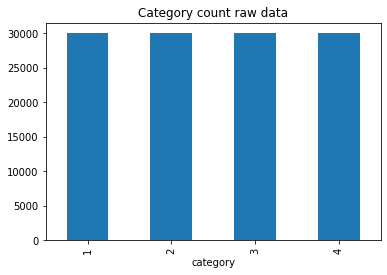

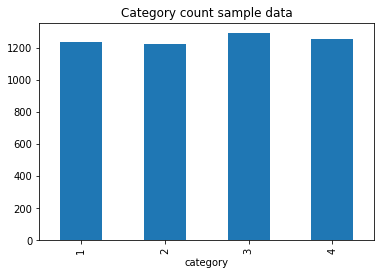

In [18]:
# bar plot of the count of unique things in each category
train_data.groupby('category').headline.count().plot.bar(ylim = 0)
plt.title("Category count raw data")
plt.show()
train_data_sample.groupby('category').headline.count().plot.bar(ylim = 0)
plt.title("Category count sample data")
plt.show()

### The number of unique documents in each category

In [9]:
print(pandas.DataFrame(train_data_sample.groupby(['category']).count()))

headline  content  content_cleaned
category                                    
1              236      236              236
2              251      251              251
3              258      258              258
4              255      255              255


### The count of observations and features

In [10]:
print("There are {} observations and {} features in this dataset. \n".\
    format(cv_matrix_df.shape[0],cv_matrix_df.shape[1]))

There are 1000 observations and 893 features in this dataset. 



### A description of the categories

In [11]:
categories = train_data_sample.groupby("category")
categories.describe().head()

headline                                                            \
            count unique                                                top   
category                                                                      
1             236    236  Bush's Convention Tops Kerry's in Primetime Po...   
2             251    251                          Edwards banned from Games   
3             258    258           Consumer Sentiment Improves in November    
4             255    255      Arguments conclude in evolution sticker trial   

              content         \
         freq   count unique   
category                       
1           1     236    235   
2           1     251    251   
3           1     258    258   
4           1     255    255   

                                                                  \
                                                        top freq   
category                                                           
1          TAIPEI (Reuters) - The pro-independence party...    2   
2         ISTANBUL, Turkey -- Striker Andriy Shevchenko ...    1   
3         The Congress-led UPA government decided on Wed...    1   
4         com September 14, 2004, 4:00 AM PT. With the e...    1   

         content_cleaned         \
                   count unique   
category                          
1                    236    235   
2                    251    251   
3                    258    258   
4                    255    255   

                                                                  
                                                        top freq  
category                                                          
1          TAIPEI (Reuters) - The pro-independence party...    2  
2          NEW YORK (Reuters) - Lamar Odom supplemented ...    1  
3         The Congress-led UPA government decided on Wed...    1  
4         AP - The  on Thursday filed the first case in ...    1

 ### WordCloud/TagCloud of the top words in the headlines

In [12]:
# prepare the dictionary to be used in wordcloud
word_count_dict = {}
for word in vocab:
    word_count_dict[word] = int(sum(cv_matrix_df.loc[:, word))

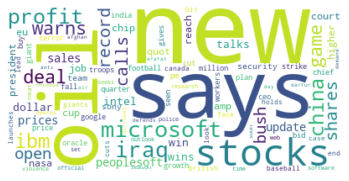

In [13]:
# generate a word cloud image with top 100 words and 80% horizontal:
wordcloud = WordCloud(max_words=100, prefer_horizontal=0.8, background_color='white').\
            generate_from_frequencies(word_count_dict)

# display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

 ### Plots of the data

 Bar plot of the top word counts

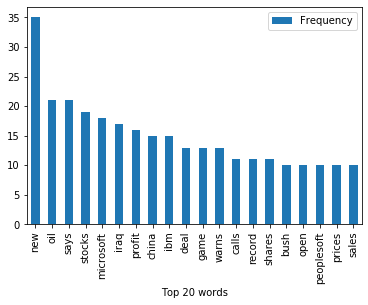

In [18]:
from collections import Counter

counter = Counter(word_count_dict)

freq_df = pandas.DataFrame.from_records(counter.most_common(20),
                                        columns=['Top 20 words', 'Frequency'])
freq_df.plot(kind='bar', x='Top 20 words');